### Лабораторна робота №5, Обробка та аналіз текстових даних на Python, Варіант 14
**Виконав**: студент групи ІП-11, Лошак Віктор Іванович<br>
**Перевірив**: Юлія Тимофєєва Сергіївна<br>

**Тема роботи**: Моделювання тем<br>
**Мета роботи**: Ознайомитись з вирішенням задач пошуку ключових слів та моделювання тем.

18.03.2024

**Завдання**:<br>
1. Застосувати прихований розподіл Діріхле бібліотеки scikit-learn для моделювання тем. Обрати оптимальну кількість тем, оцінивши та порівнявши різні моделі. Вивести терми, що описують кожну з тем.
2. Використати текст chesterton-ball.txt з корпусу gutenberg бібліотеки nltk та вивести ключові біграми.

**Task**:<br>
1. Apply the hidden Dirichlet distribution of the scikit-learn library to model topics. Choose the optimal number of topics by evaluating and comparing different models. Derive terms describing each of the topics.
2. Use the text chesterton-ball.txt from the gutenberg corpus of the nltk library and output key bigrams.

#### Task 1

In [19]:
import pandas as pd
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [14]:
file_path = 'bbc-news-data.csv'
with open(file_path, 'r', encoding='utf-8') as file:
    dialect = csv.Sniffer().sniff(file.readline())
    file.seek(0) 
    delimiter = dialect.delimiter

print(f'The CSV delimiter is: "{delimiter.encode()}"')
df = pd.read_csv(file_path, delimiter=delimiter)
df.head()

The CSV delimiter is: "b'\t'"


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [15]:
documents = df['content'].tolist()
documents[0]

' Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL\'s existing customers for high-

In [16]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(documents)


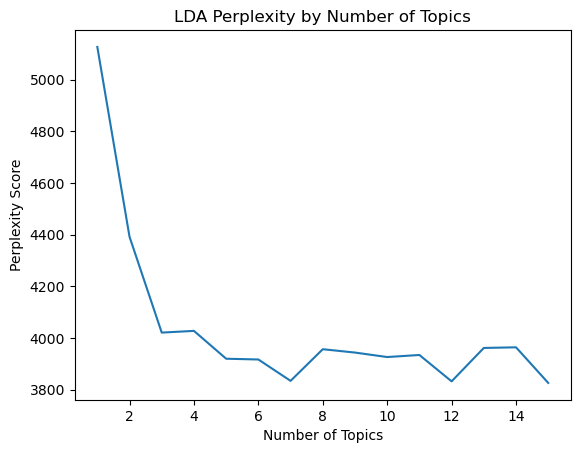

In [18]:
def compute_perplexity_scores(dtm, max_topics=15):
    perplexity_scores = []
    for n_topics in range(1, max_topics + 1):
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
        lda.fit(dtm)
        perplexity_scores.append(lda.perplexity(dtm))
    return perplexity_scores

perplexity_scores = compute_perplexity_scores(dtm, max_topics=15)

plt.plot(range(1, 16), perplexity_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.title('LDA Perplexity by Number of Topics')
plt.show()


In [20]:
n_optimal = 7 
lda_optimal = LatentDirichletAllocation(n_components=n_optimal, random_state=0)
lda_optimal.fit(dtm)

def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print_top_words(lda_optimal, vectorizer.get_feature_names_out())


Topic #1:
said mr government labour people election party blair minister new
Topic #2:
said game club time play win players united match cup
Topic #3:
said people mobile technology digital music new games phone like
Topic #4:
said mr people new security software firms search firm companies
Topic #5:
film said best year director awards won award star actor
Topic #6:
said year market growth economy sales 2004 economic new bank
Topic #7:
said music year world england new best time wales number



Щоб уникнути повторення термів в темах, використаємо наступний підхід:

topic.argsort(): This method returns an array of indices that would sort the topic array in ascending order. For example, if topic was [0.1, 0.3, 0.2], argsort() would return [0, 2, 1], which are the indices of the smallest, next smallest, and largest elements, respectively.

[:-n_top_words-1:-1]: This is a slicing operation that selects the last n_top_words indices from the sorted array. The -1 at the end means to go backwards, so it starts from the end of the array (which are the largest elements because argsort sorts in ascending order).

[feature_names[i] for i in ...]: This is a list comprehension that uses the selected indices to get the corresponding words from feature_names, which is assumed to be a list of all words in the vocabulary.

In [22]:
# def print_unique_top_words(model, feature_names, n_top_words=10):
#     topic_terms = {}  # Dictionary to hold terms for each topic
#     all_terms = set()  # Set to keep track of all terms used across topics

#     # Initial pass to get the top n_top_words for each topic
#     for topic_idx, topic in enumerate(model.components_):
#         top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
#         topic_terms[topic_idx] = top_terms
#         all_terms.update(top_terms)

#     # Check for duplicates and replace them
#     for topic_idx, terms in topic_terms.items():
#         unique_terms = [term for term in terms if list(all_terms).count(term) == 1]  # Filter out duplicates
#         extra_terms_needed = n_top_words - len(unique_terms)
        
#         if extra_terms_needed > 0:
#             # Get additional terms for the topic, skipping over ones already in unique_terms or in other topics
#             all_terms_in_other_topics = set.union(*[set(terms) for idx, terms in topic_terms.items() if idx != topic_idx])
#             candidate_terms = [feature_names[i] for i in model.components_[topic_idx].argsort() if feature_names[i] not in all_terms_in_other_topics and feature_names[i] not in unique_terms]
#             unique_terms.extend(candidate_terms[:extra_terms_needed])
        
#         # Update the list of terms for the topic and the set of all used terms
#         topic_terms[topic_idx] = unique_terms
#         all_terms = set.union(all_terms, set(unique_terms))

#     # Print the unique terms for each topic
#     for topic_idx, terms in topic_terms.items():
#         print(f"Topic #{topic_idx + 1}:")
#         print(" ".join(terms))

# # Assuming lda_optimal and vectorizer are already defined and fitted
# print_unique_top_words(lda_optimal, vectorizer.get_feature_names_out())


Topic #1:
said mr government labour people election party blair minister new
Topic #2:
said game club time play win players united match cup
Topic #3:
said people mobile technology digital music new games phone like
Topic #4:
said mr people new security software firms search firm companies
Topic #5:
film said best year director awards won award star actor
Topic #6:
said year market growth economy sales 2004 economic new bank
Topic #7:
said music year world england new best time wales number


#### Task 2

In [3]:
import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures
from nltk.corpus import stopwords
from nltk.corpus import gutenberg

In [10]:
words = gutenberg.words('chesterton-ball.txt')
stop_words = set(stopwords.words('english'))
filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
words

['[', 'The', 'Ball', 'and', 'The', 'Cross', 'by', 'G', ...]

Шукаємо біграми за найвищими значеннями поточкової взаємної інформації

In [11]:
finder = BigramCollocationFinder.from_words(filtered_words)
bigram_measures = BigramAssocMeasures()
finder.nbest(bigram_measures.pmi, 10)

[('aback', 'boisterous'),
 ('abelard', 'anatole'),
 ('abide', 'uttermost'),
 ('abstractedly', 'boring'),
 ('accommodated', 'indoors'),
 ('ace', 'spades'),
 ('active', 'birdlike'),
 ('adam', 'eve'),
 ('adult', 'reformatory'),
 ('adverse', 'theories')]

Шукаємо біграми за частотою зустрічі:

In [9]:
finder.apply_freq_filter(3)  
scored = finder.score_ngrams(bigram_measures.raw_freq)

top_10_bigrams = sorted(scored, key=lambda x: x[1], reverse=True)[:10]
for bigram, freq in top_10_bigrams:
    print(bigram, freq)

('said', 'turnbull') 0.003046707793025305
('said', 'macian') 0.0021150698728440134
('project', 'gutenberg') 0.0007302026941961475
('said', 'evan') 0.0007050232909480046
('macian', 'said') 0.0006294850812035755
('let', 'us') 0.0006043056779554324
('mr', 'turnbull') 0.0005539468714591464
('asked', 'turnbull') 0.0005287674682110034
('like', 'one') 0.0005287674682110034
('turnbull', 'said') 0.0005287674682110034


### Висновок:
В ході виконання даної лабораторної роботи я ознайомився з методами обробки та аналізу текстових даних на Python, використовуючи бібліотеки NLTK та scikit-learn. Зокрема, я навчився застосовувати модель прихованого розподілу Діріхле для виявлення тем в текстових документах, що дозволило глибше зрозуміти структуру та ключові ідеї набору даних новин. Обрання оптимальної кількості тем з використанням оцінки перплексії дало змогу ефективно структурувати інформацію та виділити значущі теми зі збалансованою кількістю деталей. Крім того, вивчення ключових біграм із тексту "chesterton-ball.txt" допомогло виділити часто вживані словосполучення, що підкреслює стилістичні та тематичні особливості літературного твору.

Робота з CountVectorizer для перетворення текстових даних у матрицю термінів та документів була важливою частиною підготовчого процесу перед моделюванням тем, що дозволило здійснити кількісний аналіз тексту. Реалізація алгоритму LDA із використанням scikit-learn забезпечила знаходження закономірностей у великих обсягах даних без необхідності детального ручного аналізу кожного документа.

Протягом виконання другого завдання я навчився використовувати бібліотеку NLTK для ефективного вилучення біграм із тексту, що є ключовим аспектом лінгвістичного аналізу і допомагає краще розуміти зв'язки між словами у тексті.